<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-and-prepare-dataset" data-toc-modified-id="Get-and-prepare-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get and prepare dataset</a></span></li><li><span><a href="#Build-and-train-the-model" data-toc-modified-id="Build-and-train-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build and train the model</a></span><ul class="toc-item"><li><span><a href="#Scale-target" data-toc-modified-id="Scale-target-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Scale target</a></span></li><li><span><a href="#Split-data-set" data-toc-modified-id="Split-data-set-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split data set</a></span></li><li><span><a href="#Adjust-the-parameters-of-the-model" data-toc-modified-id="Adjust-the-parameters-of-the-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Adjust the parameters of the model</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Check-the-parameters-of-the-best-model" data-toc-modified-id="Check-the-parameters-of-the-best-model-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Check the parameters of the best model</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

In [1]:
#import all libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#preprocessing and model selection
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, train_test_split, cross_val_score

#regression model metrics
from sklearn.metrics import mean_squared_error, r2_score

#regression models
from sklearn.svm import LinearSVR

## Get and prepare dataset

In [2]:
#download the dataset take 4 columns by the link
path = 'https://simplonline-v3-prod.s3.eu-west-3.amazonaws.com/media/file/csv/bdfc59ed-c3c7-48ac-a3d3-9e54663f6c1d.csv'
target = 'SalePrice'
df = pd.read_csv(path)
df = df[["OverallQual","GrLivArea", 'Neighborhood', "SalePrice"]]

In [3]:
#check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   OverallQual   1460 non-null   int64 
 1   GrLivArea     1460 non-null   int64 
 2   Neighborhood  1460 non-null   object
 3   SalePrice     1460 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 45.8+ KB


In [4]:
#separate target from features
X = df.drop(columns = [target])
y = df[[target]]

## Build and train the model

In [5]:
#create Pipeline with transformation + model

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(
    strategy='mean')), ('scaler', StandardScaler())])

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')
            ), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(
    columns=[target]).columns
categorical_features = df.select_dtypes(include=['object']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

lsvr = Pipeline(steps=[('preprocessor', preprocessor),                       
                      ('regressor', LinearSVR())])

### Scale target

In [6]:
y_scaler = StandardScaler() #(n,1)
y_scaler.fit(y) # mean, std ->
y = y_scaler.transform(y)

### Split data set

In [7]:
#split data set on test and train data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.25,
                                                    random_state=1)

### Adjust the parameters of the model 

In [8]:
#parameters for pipeline model
paramsLinearSVR = \
{
 'regressor__C': [float(i)*0.1+0.1 for i in range(100)],
 #'regressor__dual': [True],
 #'regressor__epsilon': [0.0],
 #'regressor__fit_intercept': [True],
 #'regressor__intercept_scaling': [1.0],
 #'regressor__loss': ['epsilon_insensitive'],
 'regressor__max_iter': [ 1000*float(i+1) for i in range(10)],
 #'regressor__random_state': [19],
 'regressor__tol': [0.01],
 #'regressor__verbose': [0],

}

### Train model 

In [13]:
#cross validation
cv1 = RepeatedKFold(n_splits=10, n_repeats=4, random_state=1)

Grid = RandomizedSearchCV(lsvr, paramsLinearSVR, n_iter = 40, scoring='r2', cv=cv1)
Grid.fit(X_train, y_train.ravel()) #(n,1) -> (n,)
best_model = Grid.best_estimator_


In [14]:
Grid.cv_results_

{'mean_fit_time': array([0.02084766, 0.01841243, 0.01838323, 0.02633955, 0.02292137,
        0.01382035, 0.01888255, 0.01759245, 0.03151203, 0.02440103,
        0.02120409, 0.01916854, 0.02470824, 0.03841568, 0.02992397,
        0.03335134, 0.02252833, 0.01386709, 0.01722429, 0.02679611]),
 'std_fit_time': array([0.0014461 , 0.0017893 , 0.0033024 , 0.00312222, 0.00222872,
        0.00225789, 0.00163992, 0.00307288, 0.0035317 , 0.0031009 ,
        0.00329123, 0.00287429, 0.00312441, 0.0041694 , 0.00310605,
        0.00223156, 0.00092524, 0.00084207, 0.00295884, 0.00269726]),
 'mean_score_time': array([0.00544676, 0.00535819, 0.0083885 , 0.00643008, 0.00616453,
        0.00517691, 0.00529023, 0.00613897, 0.00814013, 0.00847656,
        0.00844424, 0.00813314, 0.01020152, 0.00988169, 0.00833654,
        0.00772625, 0.00729681, 0.00689753, 0.00753252, 0.00745644]),
 'std_score_time': array([0.00079686, 0.00188801, 0.01381986, 0.00139698, 0.00136875,
        0.00078323, 0.0008964 , 0.001337

### Check the parameters of the best model

In [15]:
#check the parameters of the best model
best_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['OverallQual', 'GrLivArea'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                      

## Results

Metrics of y_test prediction:
MSE: 1258326760.5002174
RMSE: 35472.90177727525
R2: 0.8125601047191767


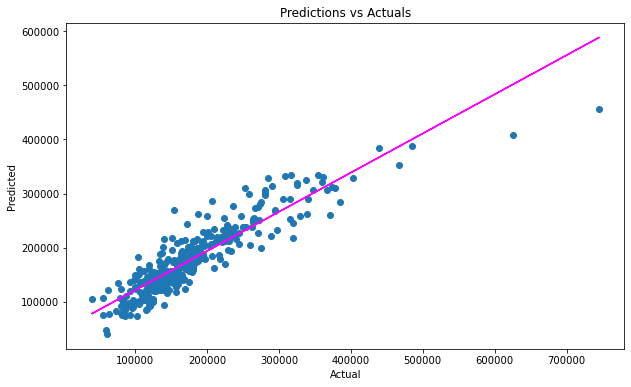

In [11]:
y_pred_scaled = best_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
y_test_real = y_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_real = y_test_real.ravel()

# Show metrics
print('Metrics of y_test prediction:')
mse = mean_squared_error(y_test_real, y_pred.ravel())
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred.ravel())
print("R2:", r2)
# Plot predicted vs actual



fig = plt.figure(figsize = (10,6))
plt.scatter(y_test_real.ravel(), y_pred.ravel())
plt.xlabel(f'Actual')
plt.ylabel(f'Predicted')
plt.title('Predictions vs Actuals')
z = np.polyfit(y_test_real.ravel(), y_pred.ravel(), 1)
p = np.poly1d(z)
plt.plot(y_test_real.ravel(), p(y_test_real.ravel()), color='magenta')
plt.show()
    